In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Step 1: import libraries 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import numpy as np
import nltk
import requests
from itertools import chain

# Step 2: Prepare the corpus
### Load, tokenize, and preprocess the Reuters dataset.
### Build the vocab, inverse mapping and numericalise the dataset

In [3]:
import requests
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import random
from collections import Counter

In [4]:
# Download necessary NLTK resources
nltk.download('punkt') 

url = "https://www.gutenberg.org/cache/epub/100/pg100.txt"

# Prepare the dataset
response = requests.get(url)
raw_text = response.text

# Define markers
start_marker = "*** START OF THE PROJECT GUTENBERG EBOOK THE COMPLETE WORKS OF WILLIAM SHAKESPEARE ***"
end_marker = "*** END OF THE PROJECT GUTENBERG EBOOK THE COMPLETE WORKS OF WILLIAM SHAKESPEARE ***"

# Find the start and end positions
start_idx = raw_text.find(start_marker) + len(start_marker)
end_idx = raw_text.find(end_marker)

# Slice out the actual content
text = raw_text[start_idx:end_idx].strip()

[nltk_data] Downloading package punkt to /Users/xiaoxuan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
#---For checking---
print(f"Extracted text length: {len(text)} characters")
print("Preview:\n", text[:1000])  # Show first 1000 characters
### End of checking

Extracted text length: 5555356 characters
Preview:
 The Complete Works of William Shakespeare

by William Shakespeare




                    Contents

    THE SONNETS
    ALL’S WELL THAT ENDS WELL
    THE TRAGEDY OF ANTONY AND CLEOPATRA
    AS YOU LIKE IT
    THE COMEDY OF ERRORS
    THE TRAGEDY OF CORIOLANUS
    CYMBELINE
    THE TRAGEDY OF HAMLET, PRINCE OF DENMARK
    THE FIRST PART OF KING HENRY THE FOURTH
    THE SECOND PART OF KING HENRY THE FOURTH
    THE LIFE OF KING HENRY THE FIFTH
    THE FIRST PART OF HENRY THE SIXTH
    THE SECOND PART OF KING HENRY THE SIXTH
    THE THIRD PART OF KING HENRY THE SIXTH
    KING HENRY THE EIGHTH
    THE LIFE AND DEATH OF KING JOHN
    THE TRAGEDY OF JULIUS CAESAR
    THE TRAGEDY OF KING LEAR
    LOVE’S LABOUR’S LOST
    THE TRAGEDY OF MACBETH
    MEASURE FOR MEASURE
    THE MERCHANT OF VENICE
    THE MERRY WIVES OF WINDSOR
    A MIDSUMMER NIGHT’S DREAM
    MUCH ADO ABOUT NOTHING
    THE TRAGEDY OF OTHELLO, THE MOOR OF VENICE
    PERICLES, PR

In [6]:
# Tokenize text into sentences, then words
sentences = sent_tokenize(text)
tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in sentences]
tokenized_sentences = [  # Remove punctuation and numbers to keep alphabetic words only
    [word for word in sentence if word.isalpha() and len(word) > 1]  # Also remove single letters
    for sentence in tokenized_sentences
]

total_words = sum(len(sentence) for sentence in tokenized_sentences)
print(f"Total sentences: {len(tokenized_sentences)}") #104698
print(f"Total words: {total_words}") #911436

# Check first 5 sentences
print("\nFirst 5 tokenized sentences:")
for i, sentence in enumerate(tokenized_sentences[:5]):
    print(f"{i+1}: {' '.join(sentence)}")

Total sentences: 104698
Total words: 911436

First 5 tokenized sentences:
1: the complete works of william shakespeare by william shakespeare contents the sonnets all well that ends well the tragedy of antony and cleopatra as you like it the comedy of errors the tragedy of coriolanus cymbeline the tragedy of hamlet prince of denmark the first part of king henry the fourth the second part of king henry the fourth the life of king henry the fifth the first part of henry the sixth the second part of king henry the sixth the third part of king henry the sixth king henry the eighth the life and death of king john the tragedy of julius caesar the tragedy of king lear love labour lost the tragedy of macbeth measure for measure the merchant of venice the merry wives of windsor midsummer night dream much ado about nothing the tragedy of othello the moor of venice pericles prince of tyre king richard the second king richard the third the tragedy of romeo and juliet the taming of the shrew the te

In [7]:
# Split the Gutenberg text into train/val/test: 80/10/10
random.seed(42)
random.shuffle(tokenized_sentences)  # Shuffle sentences for better distribution

total_sentences = len(tokenized_sentences)
train_size = int(total_sentences * 0.8)
val_size = int(total_sentences * 0.1)
#test_size = remaining 10%

# Split the data
train_data_sentences = tokenized_sentences[:train_size]
val_data_sentences = tokenized_sentences[train_size:train_size + val_size]
test_data_sentences = tokenized_sentences[train_size + val_size:]

print(f"\nDataset split:")
print(f"Train sentences: {len(train_data_sentences)}") #Train sentences: 83758
print(f"Val sentences: {len(val_data_sentences)}") #Val sentences: 10469
print(f"Test sentences: {len(test_data_sentences)}") #Test sentences: 10471


Dataset split:
Train sentences: 83758
Val sentences: 10469
Test sentences: 10471


In [8]:
# Build vocabulary from training data only
counter = Counter(token for sentence in train_data_sentences for token in sentence)
print(f"Unique words in training data: {len(counter)}") #Unique words in training data: 22006

vocab = {word: idx for idx, (word, _) in enumerate(counter.most_common(), start=4)}
vocab.update({"<unk>": 0, "<pad>": 1, "<bos>": 2, "<eos>": 3})

# Create inverse vocabulary mapping
inv_vocab = {idx: word for word, idx in vocab.items()}

#print(f"Final vocabulary size: {len(vocab)}") #Final vocabulary size: 21510

Unique words in training data: 22006


In [9]:
# Numericalize data: Convert words to IDs
def numericalize(data, vocab):
    numericalized = []
    for sentence in data:
        # Add <bos> at start and <eos> at end
        numericalized.append([vocab["<bos>"]] + [vocab.get(word, vocab["<unk>"]) for word in sentence] + [vocab["<eos>"]])
    return numericalized

# Convert all splits to numerical format
train_data = numericalize(train_data_sentences, vocab)
val_data = numericalize(val_data_sentences, vocab)
test_data = numericalize(test_data_sentences, vocab)

In [10]:
########FOR CHECKING######

# Check the numericalized data
print(f"\nNumericalized data sample:")
print(f"Original sentence: {' '.join(train_data_sentences[0])}")
print(f"Numericalized: {train_data[0][:10]}...")  # Show first 10 tokens

# Check average sentence lengths
train_lengths = [len(sentence) for sentence in train_data]
val_lengths = [len(sentence) for sentence in val_data]
test_lengths = [len(sentence) for sentence in test_data]

# Print some Dataset statistics
print(f"\nAverage sentence lengths:")
print(f"Train: {sum(train_lengths)/len(train_lengths):.1f} tokens") #10.7 tokens
print(f"Val: {sum(val_lengths)/len(val_lengths):.1f} tokens") #10.8 tokens
print(f"Test: {sum(test_lengths)/len(test_lengths):.1f} tokens") #10.6 tokens
print(f"- Total vocabulary size: {len(vocab):,}") #Total vocabulary size: 22,010
print(f"- Training sentences: {len(train_data):,}") #Training sentences: 83,758
print(f"- Validation sentences: {len(val_data):,}") #Validation sentences: 10,469
print(f"- Test sentences: {len(test_data):,}") #Test sentences: 10,471
print(f"- Total training tokens: {sum(len(s) for s in train_data):,}") #Total training tokens: 896,922
print(f"- Total validation tokens: {sum(len(s) for s in val_data):,}") #Total validation tokens: 112,618
print(f"- Total test tokens: {sum(len(s) for s in test_data):,}") #Total test tokens: 111,292


Numericalized data sample:
Original sentence: that were to blow at fire in hope to quench it for who digs hills because they do aspire throws down one mountain to cast up higher
Numericalized: [2, 11, 87, 6, 1026, 51, 383, 10, 292, 6]...

Average sentence lengths:
Train: 10.7 tokens
Val: 10.8 tokens
Test: 10.6 tokens
- Total vocabulary size: 22,010
- Training sentences: 83,758
- Validation sentences: 10,469
- Test sentences: 10,471
- Total training tokens: 896,922
- Total validation tokens: 112,618
- Total test tokens: 111,292


In [11]:
# Show most common words
print("\nTop 10 most common words:")
for word, count in counter.most_common(10):
    print(f"{word}: {count}")
#ANS: the, and, to, of, you, my, in, that, is, not


Top 10 most common words:
the: 24295
and: 22729
to: 16670
of: 14868
you: 11736
my: 10506
in: 9972
that: 9792
not: 7918
is: 7914


# SECTION A: RNN Base Model

## Step 3: Define Dataset and DataLoader (Improved)
### Create a custom PyTorch dataset for batching.

In [12]:
class ShakespeareDataset(Dataset):
    def __init__(self, data, seq_len):
        self.samples = []
        self.seq_len = seq_len

        # Build list of all valid subsequences
        for sentence in data:
            if len(sentence) > seq_len:  # only use long enough sentences
                for i in range(len(sentence) - seq_len):
                    x = sentence[i:i + seq_len]
                    y = sentence[i + 1:i + seq_len + 1]
                    self.samples.append((x, y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)
    

In [13]:
# Hyperparameters
seq_len = 128

# Create datasets
train_dataset = ShakespeareDataset(train_data, seq_len)
val_dataset = ShakespeareDataset(val_data, seq_len)
test_dataset = ShakespeareDataset(test_data, seq_len)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
#DataLoader: Automatically batches and shuffles data for training.

## Step 4: Build the RNN Model

In [14]:
class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, pad_idx, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=pad_idx)
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        embedded = self.embedding(x)  # Shape: (batch_size, seq_len, embed_size)
        output, hidden = self.rnn(embedded, hidden)  # RNN output and hidden state
        output = self.dropout(output) # Apply dropout
        output = self.fc(output)  # Shape: (batch_size, seq_len, vocab_size)
        return output, hidden

## Step 5: Train the Model

In [15]:
import numpy as np
# Model hyperparameters
vocab_size = len(vocab)
embed_size = 128
hidden_size = 256
num_layers = 1

model = RNNLanguageModel(vocab_size, embed_size, hidden_size, num_layers, pad_idx=vocab["<pad>"])
criterion = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"])
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=1)

In [16]:
# ----- Tracking -----
train_losses, train_PPL, val_losses, val_PPL = [], [], [], []

def clip_gradients(model, max_norm=1.0):
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

# Training loop
num_epochs = 10
grad_accum_steps = 4
import time

In [17]:
start_time = time.time()
for epoch in range(num_epochs):
    ## ----- Training ----- 
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for step, (x, y) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        output, _ = model(x)
        loss = criterion(output.view(-1, vocab_size), y.view(-1))
        loss = loss / grad_accum_steps
        loss.backward()

        if (step + 1) % grad_accum_steps == 0:
            clip_gradients(model, max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item() * grad_accum_steps

    avg_train_loss = total_loss / len(train_loader)
    train_perplexity = np.exp(avg_train_loss)
    train_losses.append(avg_train_loss)
    train_PPL.append(train_perplexity)

    ## ----- Validation -----
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:   # no tqdm here
            output, _ = model(x)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_perplexity = np.exp(avg_val_loss)
    val_losses.append(avg_val_loss)
    val_PPL.append(val_perplexity)

    scheduler.step(avg_val_loss)

    ## ----- Logs -----
    print(f"Epoch {epoch+1} | "
          f"Train Loss: {avg_train_loss:.4f} | Train PPL: {train_perplexity:.2f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val PPL: {val_perplexity:.2f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")

# ----- End time -----
end_time = time.time()
print(f"Total training time: {(end_time - start_time)/60:.2f} minutes")

RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 1: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:20<00:00,  1.12it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 1 | Train Loss: 9.7254 | Train PPL: 16737.13 | Val Loss: 9.7516 | Val PPL: 17180.98 | LR: 0.001000


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 2: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:17<00:00,  1.35it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 2 | Train Loss: 8.4682 | Train PPL: 4760.99 | Val Loss: 8.5393 | Val PPL: 5111.53 | LR: 0.001000


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 3: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:22<00:00,  1.02it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 3 | Train Loss: 6.9748 | Train PPL: 1069.36 | Val Loss: 8.0089 | Val PPL: 3007.46 | LR: 0.001000


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 4: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:19<00:00,  1.19it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 4 | Train Loss: 6.2139 | Train PPL: 499.65 | Val Loss: 8.0179 | Val PPL: 3034.67 | LR: 0.001000


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 5: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:21<00:00,  1.08it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 5 | Train Loss: 5.8435 | Train PPL: 344.98 | Val Loss: 8.0811 | Val PPL: 3232.72 | LR: 0.000500


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 6: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:22<00:00,  1.03it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 6 | Train Loss: 5.6731 | Train PPL: 290.92 | Val Loss: 8.0663 | Val PPL: 3185.41 | LR: 0.000500


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 7: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:22<00:00,  1.04it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 7 | Train Loss: 5.5352 | Train PPL: 253.47 | Val Loss: 8.0034 | Val PPL: 2991.08 | LR: 0.000500


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 8: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:20<00:00,  1.12it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 8 | Train Loss: 5.4076 | Train PPL: 223.10 | Val Loss: 7.9996 | Val PPL: 2979.68 | LR: 0.000500


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 9: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:21<00:00,  1.05it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 9 | Train Loss: 5.3069 | Train PPL: 201.73 | Val Loss: 7.9562 | Val PPL: 2853.24 | LR: 0.000500


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 10: 100%|████████████████████████████████████████████████████████████████| 23/23 [00:15<00:00,  1.44it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 10 | Train Loss: 5.1998 | Train PPL: 181.23 | Val Loss: 7.9395 | Val PPL: 2805.94 | LR: 0.000500
Total training time: 3.59 minutes


In [18]:
# Create a dataframe for all values
import pandas as pd
data = {
    "Train Loss": train_losses,
    "Train PPL": train_PPL,
    "Val Loss": val_losses,
    "Val PPL": val_PPL
}
# Build DataFrame
df = pd.DataFrame(data, index=[f"Epoch {i+1}" for i in range(num_epochs)])


# Add final row for training time
training_time_minutes = (end_time - start_time) / 60
df.loc[num_epochs] = [f"---", f"---", f"---", f"Time: {training_time_minutes:.2f} min"]

# Show table
print(df)

         Train Loss     Train PPL  Val Loss         Val PPL
Epoch 1    9.725385  16737.132682  9.751558    17180.984426
Epoch 2     8.46821   4760.985044  8.539254     5111.531189
Epoch 3    6.974813   1069.357029  8.008851     3007.458276
Epoch 4    6.213911    499.651342  8.017858     3034.668742
Epoch 5      5.8435    344.984717   8.08108      3232.72133
Epoch 6    5.673055    290.922037  8.066335     3185.407449
Epoch 7    5.535247    253.470501   8.00339      2991.07952
Epoch 8    5.407598    223.095041  7.999572     2979.681246
Epoch 9    5.306913    201.726524  7.956209     2853.236056
Epoch 10   5.199766    181.229858  7.939494     2805.939646
10              ---           ---       ---  Time: 3.59 min


## Step 6: Plot training and validation loss curves

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

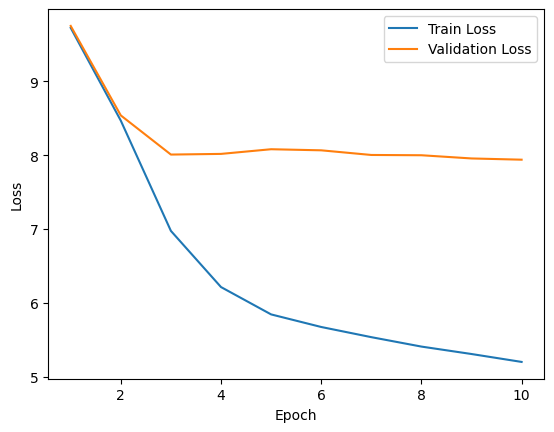

In [19]:
import matplotlib.pyplot as plt

epochs = [i + 1 for i in range(len(train_losses))]  # start from 1 instead of 0

plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Step 7: Evaluate the Model

In [20]:
def cross_entropy_loss_and_perplexity(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x,y in data_loader:
            output, _ =model(x)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))
            total_loss += loss.item()
    avg_loss =  total_loss/ len(data_loader)
    perplexity = np.exp(avg_loss)
    return avg_loss, perplexity

### Evaluation

In [21]:
val_loss, val_PPL = cross_entropy_loss_and_perplexity(model, val_loader)
test_loss, test_PPL = cross_entropy_loss_and_perplexity(model, test_loader)
print(f"Val Loss: {val_loss:.4f}, Test PPL: {val_PPL:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test PPL: {test_PPL:.4f}")

Val Loss: 7.9395, Test PPL: 2805.9396
Test Loss: 9.1652, Test PPL: 9558.3617


## Step 8: Generate Text 

In [22]:
def generate_text(model, start_seq, max_len=1000, temperature=1, max_words=None):
    model.eval()
    idx_seq = [vocab.get(word, vocab["<unk>"]) for word in start_seq]
    x = torch.tensor([idx_seq], dtype=torch.long)
    hidden = None
    result = start_seq.copy()

    for _ in range(max_len):
        output, hidden = model(x, hidden)
        logits = output[:, -1, :] / temperature
        probs = torch.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1).item()

        if next_token == vocab["<eos>"]:
            break

        result.append(inv_vocab[next_token])
        if max_words is not None and len(result) >= max_words:
            break

        x = torch.tensor([[next_token]], dtype=torch.long)

    return " ".join(result)

In [23]:
for T in [0.7, 1.0, 1.3]:
    print(f"[Sampling with T={T}] ")
    print(generate_text(model, ["the"], max_len=1000, max_words=150, temperature=T))

[Sampling with T=0.7] 
the moor of this and the our the his to eleventh the world the phoenix you the life and wives the subtle of king the to ho to the duke of the thereby john of henry to the all when richard of king richard the tragedy of commonwealth the two of henry tyre tempest of the king increase of denmark her the sweats of the king mortimer the shadow that and the throne of bullen titus the second of old the rain of make the tragedy the and of the child of canterbury and the sonnets of war measure durst of pericles doth jailer substitute the tragedy of king and the tragedy of henry duke the tragedy of king ta ado to the two hyperion of the hath of on to the intertissued two the with of the abergavenny and king henry the third of war the king baboon the
[Sampling with T=1.0] 
the two women of st dread to once or the shrew tomb richard which through king friend seleucus the sir hugh of out our keeper making only us repaired stand an bread with another of verona is six kinsmen b

# SECTION B: ABLATION STUDY ON DROPOUT = 0.1

## Steps 1 - 3 are the same as above
## Step 4: Build the RNN Model

In [24]:
class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, pad_idx, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=pad_idx)
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        embedded = self.embedding(x)  # Shape: (batch_size, seq_len, embed_size)
        output, hidden = self.rnn(embedded, hidden)  # RNN output and hidden state
        output = self.dropout(output) # Apply dropout
        output = self.fc(output)  # Shape: (batch_size, seq_len, vocab_size)
        return output, hidden

## Step 5: Train the Model

In [25]:
import numpy as np
# Model hyperparameters
vocab_size = len(vocab)
embed_size = 128
hidden_size = 256
num_layers = 1

model = RNNLanguageModel(vocab_size, embed_size, hidden_size, num_layers, pad_idx=vocab["<pad>"])
criterion = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"])
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=1)

In [26]:
# ----- Tracking -----
train_losses, train_PPL, val_losses, val_PPL = [], [], [], []

def clip_gradients(model, max_norm=1.0):
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

# Training loop
num_epochs = 10
grad_accum_steps = 4
import time

In [27]:
start_time = time.time()
for epoch in range(num_epochs):
    ## ----- Training ----- 
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for step, (x, y) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        output, _ = model(x)
        loss = criterion(output.view(-1, vocab_size), y.view(-1))
        loss = loss / grad_accum_steps
        loss.backward()

        if (step + 1) % grad_accum_steps == 0:
            clip_gradients(model, max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item() * grad_accum_steps

    avg_train_loss = total_loss / len(train_loader)
    train_perplexity = np.exp(avg_train_loss)
    train_losses.append(avg_train_loss)
    train_PPL.append(train_perplexity)

    ## ----- Validation -----
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:   # no tqdm here
            output, _ = model(x)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_perplexity = np.exp(avg_val_loss)
    val_losses.append(avg_val_loss)
    val_PPL.append(val_perplexity)

    scheduler.step(avg_val_loss)

    ## ----- Logs -----
    print(f"Epoch {epoch+1} | "
          f"Train Loss: {avg_train_loss:.4f} | Train PPL: {train_perplexity:.2f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val PPL: {val_perplexity:.2f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")

# ----- End time -----
end_time = time.time()
print(f"Total training time: {(end_time - start_time)/60:.2f} minutes")

RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 1: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:22<00:00,  1.04it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 1 | Train Loss: 9.7318 | Train PPL: 16844.46 | Val Loss: 9.7741 | Val PPL: 17572.45 | LR: 0.001000


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 2: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:18<00:00,  1.24it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 2 | Train Loss: 8.4975 | Train PPL: 4902.41 | Val Loss: 8.4886 | Val PPL: 4858.89 | LR: 0.001000


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 3: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:19<00:00,  1.15it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 3 | Train Loss: 6.9540 | Train PPL: 1047.35 | Val Loss: 8.1244 | Val PPL: 3375.95 | LR: 0.001000


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 4: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:35<00:00,  1.54s/it]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 4 | Train Loss: 6.2166 | Train PPL: 500.99 | Val Loss: 8.2013 | Val PPL: 3645.59 | LR: 0.001000


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 5: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:19<00:00,  1.18it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 5 | Train Loss: 5.8796 | Train PPL: 357.68 | Val Loss: 8.3856 | Val PPL: 4383.36 | LR: 0.000500


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 6: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:17<00:00,  1.34it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 6 | Train Loss: 5.7046 | Train PPL: 300.24 | Val Loss: 8.2404 | Val PPL: 3791.07 | LR: 0.000500


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 7: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:19<00:00,  1.15it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 7 | Train Loss: 5.5421 | Train PPL: 255.20 | Val Loss: 8.0597 | Val PPL: 3164.20 | LR: 0.000500


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 8: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:16<00:00,  1.38it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 8 | Train Loss: 5.4223 | Train PPL: 226.39 | Val Loss: 7.9713 | Val PPL: 2896.54 | LR: 0.000500


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 9: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:23<00:00,  1.00s/it]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 9 | Train Loss: 5.2800 | Train PPL: 196.37 | Val Loss: 7.8588 | Val PPL: 2588.50 | LR: 0.000500


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 10: 100%|████████████████████████████████████████████████████████████████| 23/23 [00:51<00:00,  2.22s/it]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 10 | Train Loss: 5.1641 | Train PPL: 174.88 | Val Loss: 7.8355 | Val PPL: 2528.73 | LR: 0.000500
Total training time: 4.38 minutes


In [28]:
# Create a dataframe for all values
import pandas as pd
data = {
    "Train Loss": train_losses,
    "Train PPL": train_PPL,
    "Val Loss": val_losses,
    "Val PPL": val_PPL
}
# Build DataFrame
df = pd.DataFrame(data, index=[f"Epoch {i+1}" for i in range(num_epochs)])


# Add final row for training time
training_time_minutes = (end_time - start_time) / 60
df.loc[num_epochs] = [f"---", f"---", f"---", f"Time: {training_time_minutes:.2f} min"]

# Show table
print(df)


         Train Loss    Train PPL  Val Loss         Val PPL
Epoch 1    9.731777  16844.45877  9.774087     17572.44508
Epoch 2    8.497481  4902.406323  8.488564     4858.886091
Epoch 3     6.95402  1047.351959  8.124433     3375.953039
Epoch 4    6.216592   500.993175  8.201273     3645.587364
Epoch 5    5.879649    357.68356  8.385572     4383.364509
Epoch 6    5.704569   300.236078  8.240404     3791.069912
Epoch 7    5.542061   255.203415  8.059657     3164.203424
Epoch 8    5.422281   226.394874  7.971271     2896.536358
Epoch 9    5.280021   196.374037  7.858834     2588.500373
Epoch 10   5.164116   174.882766  7.835472     2528.729782
10              ---          ---       ---  Time: 4.38 min


## Step 6: Plot training and validation loss curves

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

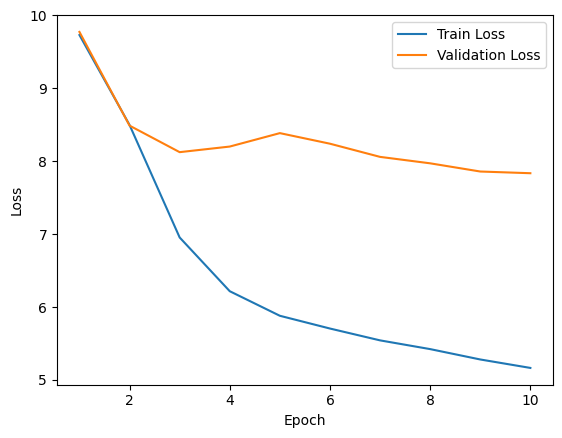

In [29]:
import matplotlib.pyplot as plt

epochs = [i + 1 for i in range(len(train_losses))]  # start from 1 instead of 0

plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Step 7: Evaluate the Model

In [30]:
def cross_entropy_loss_and_perplexity(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x,y in data_loader:
            output, _ =model(x)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))
            total_loss += loss.item()
    avg_loss =  total_loss/ len(data_loader)
    perplexity = np.exp(avg_loss)
    return avg_loss, perplexity

### Evaluation

In [31]:
val_loss, val_PPL = cross_entropy_loss_and_perplexity(model, val_loader)
test_loss, test_PPL = cross_entropy_loss_and_perplexity(model, test_loader)
print(f"Val Loss: {val_loss:.4f}, Test PPL: {val_PPL:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test PPL: {test_PPL:.4f}")

Val Loss: 7.8355, Test PPL: 2528.7298
Test Loss: 9.0275, Test PPL: 8328.7819


## Step 8: Generate Text 

In [35]:
def generate_text(model, start_seq, max_len=1000, temperature=1, max_words=None):
    model.eval()
    idx_seq = [vocab.get(word, vocab["<unk>"]) for word in start_seq]
    x = torch.tensor([idx_seq], dtype=torch.long)
    hidden = None
    result = start_seq.copy()

    for _ in range(max_len):
        output, hidden = model(x, hidden)
        logits = output[:, -1, :] / temperature
        probs = torch.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1).item()

        if next_token == vocab["<eos>"]:
            break

        result.append(inv_vocab[next_token])
        if max_words is not None and len(result) >= max_words:
            break

        x = torch.tensor([[next_token]], dtype=torch.long)

    return " ".join(result)

In [36]:
for T in [0.7, 1.0, 1.3]:
    print(f"[Sampling with T={T}] ")
    print(generate_text(model, ["the"], max_len=1000, max_words=150, temperature=T))

[Sampling with T=0.7] 
the riper of hell child green of thou of cressida and from with feeding that earl the tragedy of and nothing us richard hell the king of and the tide of abergavenny with as to part of weddings to the sonnets the wretched to oak the sixth of this with the second the farced of the first should with to in to to the tragedy of duke of hell the crown of duke of unlucky and the from the for of might oath lucius to with sir of imperial and the tragedy the two of king her the to with by the tragedy of enforced forgetfulness the tragedy of the stock of too afterwards the in the life of in an his two and part the and of the henry the tragedy of king of the second the duke of of in king john should st and singing the to
[Sampling with T=1.0] 
the tragedy plural chapeless thy king queen present to the desire archbishop afterwards king lear we sheep courses ancient six and libertine fed been complaint the dread your and several times him lies tragedy of of york bird you raven

# SECTION C: ABLATION STUDY ON CONTEXT LENGTH = 256

## Steps 1 - 2 are the same as above

## Step 3: Define Dataset and DataLoader

In [40]:
class ShakespeareDataset(Dataset):
    def __init__(self, data, seq_len):
        self.samples = []
        self.seq_len = seq_len

        # Build list of all valid subsequences
        for sentence in data:
            if len(sentence) > seq_len:  # only use long enough sentences
                for i in range(len(sentence) - seq_len):
                    x = sentence[i:i + seq_len]
                    y = sentence[i + 1:i + seq_len + 1]
                    self.samples.append((x, y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

In [46]:
# Hyperparameters
seq_len = 64

# Create datasets
train_dataset = ShakespeareDataset(train_data, seq_len)
val_dataset = ShakespeareDataset(val_data, seq_len)
test_dataset = ShakespeareDataset(test_data, seq_len)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
#DataLoader: Automatically batches and shuffles data for training.

## Step 4: Build the RNN Model

In [47]:
class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, pad_idx, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=pad_idx)
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        embedded = self.embedding(x)  # Shape: (batch_size, seq_len, embed_size)
        output, hidden = self.rnn(embedded, hidden)  # RNN output and hidden state
        output = self.dropout(output) # Apply dropout
        output = self.fc(output)  # Shape: (batch_size, seq_len, vocab_size)
        return output, hidden

## Step 5: Train the Model

In [48]:
import numpy as np
# Model hyperparameters
vocab_size = len(vocab)
embed_size = 128
hidden_size = 256
num_layers = 1

model = RNNLanguageModel(vocab_size, embed_size, hidden_size, num_layers, pad_idx=vocab["<pad>"])
criterion = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"])
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=1)

In [49]:
# ----- Tracking -----
train_losses, train_PPL, val_losses, val_PPL = [], [], [], []

def clip_gradients(model, max_norm=1.0):
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

# Training loop
num_epochs = 10
grad_accum_steps = 4
import time

In [50]:
start_time = time.time()
for epoch in range(num_epochs):
    ## ----- Training ----- 
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for step, (x, y) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        output, _ = model(x)
        loss = criterion(output.view(-1, vocab_size), y.view(-1))
        loss = loss / grad_accum_steps
        loss.backward()

        if (step + 1) % grad_accum_steps == 0:
            clip_gradients(model, max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item() * grad_accum_steps

    avg_train_loss = total_loss / len(train_loader)
    train_perplexity = np.exp(avg_train_loss)
    train_losses.append(avg_train_loss)
    train_PPL.append(train_perplexity)

    ## ----- Validation -----
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:   # no tqdm here
            output, _ = model(x)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_perplexity = np.exp(avg_val_loss)
    val_losses.append(avg_val_loss)
    val_PPL.append(val_perplexity)

    scheduler.step(avg_val_loss)

    ## ----- Logs -----
    print(f"Epoch {epoch+1} | "
          f"Train Loss: {avg_train_loss:.4f} | Train PPL: {train_perplexity:.2f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val PPL: {val_perplexity:.2f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")

# ----- End time -----
end_time = time.time()
print(f"Total training time: {(end_time - start_time)/60:.2f} minutes")

RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 1: 100%|███████████████████████████████████████████████████████████████| 318/318 [02:07<00:00,  2.50it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 1 | Train Loss: 7.3768 | Train PPL: 1598.53 | Val Loss: 7.5711 | Val PPL: 1941.21 | LR: 0.001000


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 2: 100%|███████████████████████████████████████████████████████████████| 318/318 [01:49<00:00,  2.92it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 2 | Train Loss: 6.4450 | Train PPL: 629.55 | Val Loss: 7.4793 | Val PPL: 1770.95 | LR: 0.001000


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 3: 100%|███████████████████████████████████████████████████████████████| 318/318 [01:43<00:00,  3.07it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 3 | Train Loss: 5.7329 | Train PPL: 308.87 | Val Loss: 7.3743 | Val PPL: 1594.42 | LR: 0.001000


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 4: 100%|███████████████████████████████████████████████████████████████| 318/318 [01:44<00:00,  3.06it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 4 | Train Loss: 4.8515 | Train PPL: 127.93 | Val Loss: 7.4014 | Val PPL: 1638.34 | LR: 0.001000


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 5: 100%|███████████████████████████████████████████████████████████████| 318/318 [01:47<00:00,  2.97it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 5 | Train Loss: 3.9611 | Train PPL: 52.51 | Val Loss: 7.5193 | Val PPL: 1843.29 | LR: 0.000500


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 6: 100%|███████████████████████████████████████████████████████████████| 318/318 [01:47<00:00,  2.95it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 6 | Train Loss: 3.3529 | Train PPL: 28.59 | Val Loss: 7.6058 | Val PPL: 2009.78 | LR: 0.000500


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 7: 100%|███████████████████████████████████████████████████████████████| 318/318 [01:39<00:00,  3.19it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 7 | Train Loss: 3.0097 | Train PPL: 20.28 | Val Loss: 7.6986 | Val PPL: 2205.16 | LR: 0.000250


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 8: 100%|███████████████████████████████████████████████████████████████| 318/318 [01:40<00:00,  3.18it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 8 | Train Loss: 2.7698 | Train PPL: 15.96 | Val Loss: 7.7484 | Val PPL: 2317.82 | LR: 0.000250


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 9: 100%|███████████████████████████████████████████████████████████████| 318/318 [01:52<00:00,  2.82it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 9 | Train Loss: 2.6234 | Train PPL: 13.78 | Val Loss: 7.8016 | Val PPL: 2444.57 | LR: 0.000125


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 10: 100%|██████████████████████████████████████████████████████████████| 318/318 [01:52<00:00,  2.83it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 10 | Train Loss: 2.5196 | Train PPL: 12.42 | Val Loss: 7.8235 | Val PPL: 2498.52 | LR: 0.000125
Total training time: 19.01 minutes


In [51]:
# Create a table for all values

#import pandas as pd
data = {
    "Train Loss": train_losses,
    "Train PPL": train_PPL,
    "Val Loss": val_losses,
    "Val PPL": val_PPL
}
# Build DataFrame
df = pd.DataFrame(data, index=[f"Epoch {i+1}" for i in range(num_epochs)])


# Add final row for training time
training_time_minutes = (end_time - start_time) / 60
df.loc[num_epochs] = [f"---", f"---", f"---", f"Time: {training_time_minutes:.2f} min"]

# Show table
print(df)

         Train Loss    Train PPL  Val Loss          Val PPL
Epoch 1    7.376839  1598.528494  7.571069      1941.214877
Epoch 2    6.445003   629.548767  7.479272      1770.950713
Epoch 3    5.732917   308.868831  7.374267      1594.422269
Epoch 4    4.851465    127.92765  7.401438      1638.338473
Epoch 5    3.961063    52.513108   7.51931      1843.294453
Epoch 6    3.352945    28.586807  7.605778      2009.775694
Epoch 7     3.00969    20.281118  7.698557      2205.163916
Epoch 8    2.769793    15.955339  7.748381      2317.816608
Epoch 9    2.623394    13.782427  7.801626      2444.573209
Epoch 10   2.519625    12.423938  7.823454      2498.520473
10              ---          ---       ---  Time: 19.01 min


## Step 6: Plot training and validation loss curves


Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

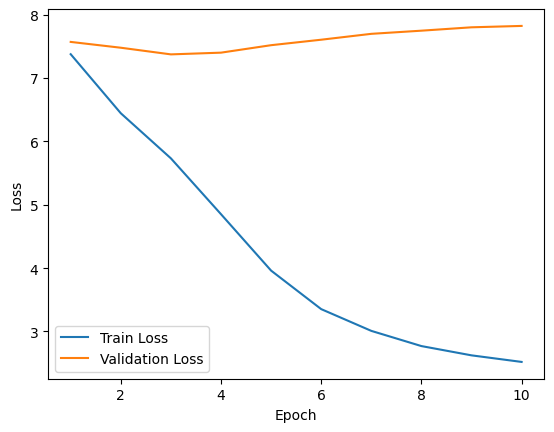

In [52]:
import matplotlib.pyplot as plt

epochs = [i + 1 for i in range(len(train_losses))]  # start from 1 instead of 0

plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Step 7: Evaluate the Model

In [39]:
def cross_entropy_loss_and_perplexity(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x,y in data_loader:
            output, _ =model(x)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))
            total_loss += loss.item()
    avg_loss =  total_loss/ len(data_loader)
    perplexity = np.exp(avg_loss)
    return avg_loss, perplexity

### Evaluation


In [54]:
val_loss, val_PPL = cross_entropy_loss_and_perplexity(model, val_loader)
test_loss, test_PPL = cross_entropy_loss_and_perplexity(model, test_loader)
print(f"Val Loss: {val_loss:.4f}, Test PPL: {val_PPL:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test PPL: {test_PPL:.4f}")

Val Loss: 7.8235, Test PPL: 2498.5205
Test Loss: 8.0073, Test PPL: 3002.8056


## Step 8: Generate Text

In [55]:
def generate_text(model, start_seq, max_len=1000, temperature=1, max_words=None):
    model.eval()
    idx_seq = [vocab.get(word, vocab["<unk>"]) for word in start_seq]
    x = torch.tensor([idx_seq], dtype=torch.long)
    hidden = None
    result = start_seq.copy()

    for _ in range(max_len):
        output, hidden = model(x, hidden)
        logits = output[:, -1, :] / temperature
        probs = torch.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1).item()

        if next_token == vocab["<eos>"]:
            break

        result.append(inv_vocab[next_token])
        if max_words is not None and len(result) >= max_words:
            break

        x = torch.tensor([[next_token]], dtype=torch.long)

    return " ".join(result)

In [56]:
for T in [0.7, 1.0, 1.3]:
    print(f"[Sampling with T={T}] ")
    print(generate_text(model, ["the"], max_len=1000, max_words=150, temperature=T))

[Sampling with T=0.7] 
the todpole the sinews and all to the listening of that fair the heavens the wanton and such upon the fear of scorn to some small distance follows gentleman bearing of timon creditors lucius servant of timon creditors philotus servant of timon creditors servant of timon creditors philotus servant of timon creditors lucius servant of timon creditors servant of isidore two servants of varro titus servant of timon creditors hortensius servant of timon creditors servant of isidore two servants of varro titus servant of timon creditors philotus servant of timon creditors servant of timon creditors lucius servant of timon creditors servant of timon creditors lucius servant of isidore two servants of varro titus servant of timon creditors servant to king richard earl of warwick earl of pembroke lord hastings lord stafford sir john mortimer uncle to the combat in the queen of your country justice in the night that all
[Sampling with T=1.0] 
the seaman shrieked the romans